# Tutorial 3: Actions, angles and frequencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from astropy.table import Table
from astropy.coordinates import SkyCoord, Distance, Galactocentric
import astropy.units as u
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel
from galpy.orbit import Orbit

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In this tutorial we will demonstrate how to compute action, angle and frequency coordinates using the Gaia RVS sample. We begin by grabbing data via TAP. Here we limit ourselves to the first $1000$ stars with radial velocities and proper motions and within $200\,\mathrm{pc}$.

In [2]:
from astroquery.gaia import Gaia
job = Gaia.launch_job_async(
    """select top 3000 ra,dec,parallax,pmra,pmdec,radial_velocity """
    """from gaiadr2.gaia_source """
    """where radial_velocity>-1000 and pmra>-1000 and parallax>5""")
table = job.get_results();

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Query finished.


As in Tutorial 2, we construct SkyCoord objects. The difference here is we can construct a Distance object from parallaxes. In theory, the measured parallax could be negative (we have restricted ourselves to positive parallax), in which case we set allow_negative=True to propagate negative parallaxes through the calculation -- they get NaN distances.

In [3]:
# allow_negative means the distance=nan if parallax<0
s = SkyCoord(ra=table['ra'],dec=table['dec'],
             distance=Distance(
                 parallax=table['parallax'].data.data*u.mas, 
                 allow_negative=True),
             pm_ra_cosdec=table['pmra'],pm_dec=table['pmdec'],
             radial_velocity=table['radial_velocity'])
galcen = s.transform_to(Galactocentric)

In [4]:
def pair_plot(data):
    g = sns.PairGrid(data, diag_sharey=False)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.kdeplot)
    for i, j in zip(*np.triu_indices_from(g.axes, 1)):
        g.axes[i, j].set_visible(False)
    for i, j in zip(*np.tril_indices_from(g.axes, 1)):
        g.axes[i,i].set_ylim(*np.percentile(data.values[:,i],[1.,99.]))
        g.axes[i,i].set_xlim(*np.percentile(data.values[:,j],[1.,99.]))
    for i in range(np.shape(g.axes)[0]):
        g.axes[i,i].set_xlim(*np.percentile(data.values[:,i],[1.,99.]))

In velocity space we see the characteristic structures. In particular, in vx against vy we see the Hyades, Hercules and Sirius very clearly.

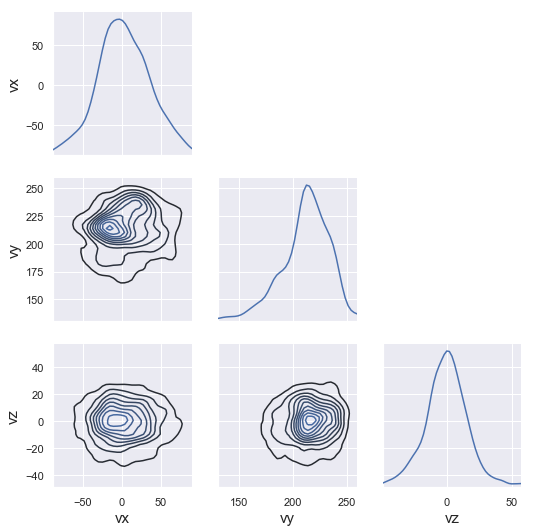

In [5]:
pair_plot(pd.DataFrame(np.array([galcen.v_x,galcen.v_y,galcen.v_z]).T,
                       columns=['vx','vy','vz']))

### Action, angles and frequencies

We now use the action-angle estimation routines in galpy. The standard method is the `Staeckel fudge' which integrates the equations for the actions using those for a Staeckel potential. We use the MWPotential2014 from galpy. A choice of a parameter $\Delta$ is required for the method. We can use the SkyCoord object in the Orbit class so the coordinate transformations are handled internally. galpy outputs the actions and frequencies in its internal coordinates where distances in units of 8 kpc and velocities 220 km/s so we scale to physical. 

In [6]:
# Initialize action-finder and compute actions, converting to physical units
aAS= actionAngleStaeckel(pot=MWPotential2014,delta=0.4,c=True)
action_unit = 8.*u.kpc * 220.*u.km/u.s
freq_unit = 1./(8.*u.kpc) * 220.*u.km/u.s

In [7]:
o = Orbit(s)
jj = aAS.actionsFreqsAngles(o.R()*u.kpc,
                            o.vR()*u.km/u.s,
                            o.vT()*u.km/u.s,
                            o.z()*u.kpc,
                            o.vz()*u.km/u.s,
                            o.phi()*u.rad)

actions = np.array(jj[:3])*action_unit
frequencies = np.array(jj[3:6])*freq_unit
angles = np.array(jj[6:])*u.rad
angles[1]=angles[1]-2.*np.pi*u.rad*(angles[1]>np.pi*u.rad)

# Convenient to work with sqrt(J_R) and sqrt(J_z)
sqrt_actions = np.array([np.sqrt(actions[0]),actions[1],np.sqrt(actions[2])])

In [8]:
actions[:,0], frequencies[:,0], angles[:,0]

(<Quantity [7.33880794e+00, 1.84714611e+03, 4.11417501e-02] km kpc / s>,
 <Quantity [34.4022353 , 25.72916766, 67.73227455] km / (kpc s)>,
 <Quantity [5.81893182, 0.04455854, 3.63249353] rad>)

Inspecting the pair plots for these quantities we see the familiar features -- spurs due to the moving groups, edges due to the selection volume.

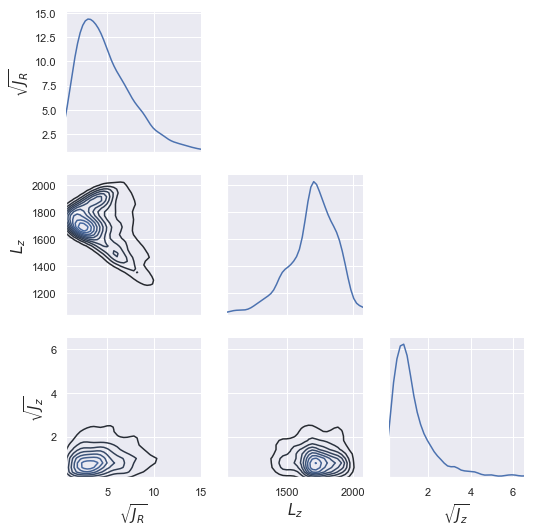

In [9]:
pair_plot(pd.DataFrame(sqrt_actions.T,
                       columns=[r'$\sqrt{J_R}$',r'$L_z$',r'$\sqrt{J_z}$']))

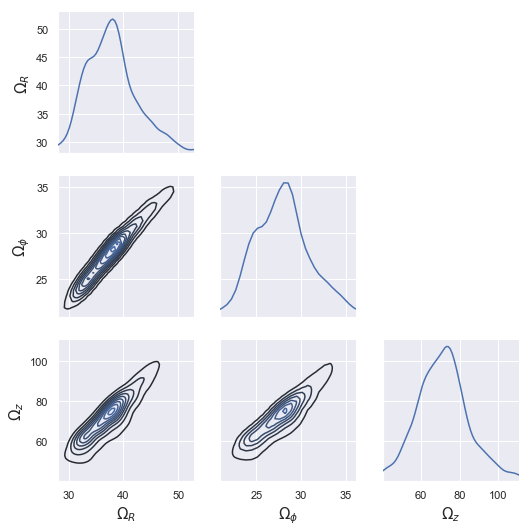

In [10]:
pair_plot(pd.DataFrame(frequencies.T,
                       columns=[r'$\Omega_R$',r'$\Omega_\phi$',r'$\Omega_z$']))

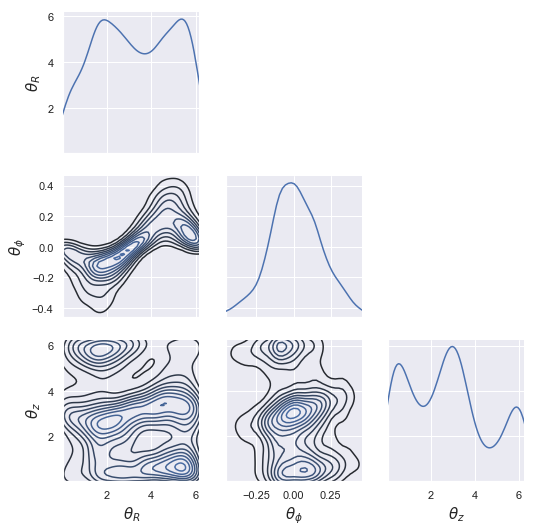

In [11]:
pair_plot(pd.DataFrame(angles.T,
                       columns=[r'$\theta_R$',r'$\theta_\phi$',r'$\theta_z$']))

We have seen how to compute action, angle and frequency coordinates. There are several things we can do next.

1. Propagate uncertainties through the calculation.

2. Attempt to find clumps in the action space.

3. Look at how these distributions change with Galactic location.

See Trick et al. (2018).